In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
metadata_path = '../../../../../metadata/MBC/merged_key_metadata.txt'
timepoint_path = '../../../../../metadata/MBC/timepoint_data.txt'

In [3]:
multi_time_points = ['TNBC_ULPWGS_14','TNBC_ULPWGS_96','TNBC_ULPWGS_48',
                     'TNBC_ULPWGS_10','TNBC_ULPWGS_44','TNBC_ULPWGS_28']

color_dict = {'+':'tab:blue','-':'tab:orange','moderate':'tab:blue'}


In [4]:
#import per patient metadata
metadata = pd.read_csv(metadata_path,sep='\t')
metadata['TimeFromMet_ToDeathOrLastFU_Months'] = metadata['merged_TimeFromMet_ToDeathOrLastFU_Days']/30
metadata = metadata[['patient_id','TNBC_ULPWGS_ID','merged_PrimaryEstrogenStatus','merged_MetsEstrogenStatus','merged_DeathCensor','TimeFromMet_ToDeathOrLastFU_Months']]
metadata  = metadata.drop_duplicates().reset_index(drop=True)
print(len(metadata))

timepoint_data = pd.read_csv(timepoint_path, sep='\t')

#merge with sample specific timepoint data and retain all samples even if they weren't used for the ER status prediction
metadata = timepoint_data.merge(metadata, on = ['patient_id'], how = 'left')
print(len(metadata))

#check that nothing got duplicated
print(len(metadata['sample'].unique()))

139
47
47


In [5]:
additional_data_dict = {'TNBC_ULPWGS_14':{(0/30):{'location':'chest wall','subtype':'-'},
                                          (26/30):{'location':'bone','subtype':'moderate'}},
                                         
                        'TNBC_ULPWGS_96':{(0/30):{'location':'breast','subtype':'moderate'},
                                          (146/30):{'location':'lymph node','subtype':'moderate'},
                                         (356/30):{'location':'lymph node','subtype':'-'}},             
                                         }


<ipython-input-6-f98a2305aa0a>:73: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(right = .8)
<ipython-input-6-f98a2305aa0a>:75: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-6-f98a2305aa0a>:73: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(right = .8)
<ipython-input-6-f98a2305aa0a>:75: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-6-f98a2305aa0a>:73: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layou

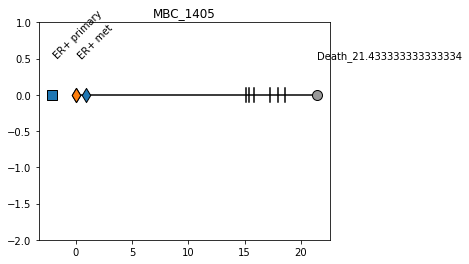

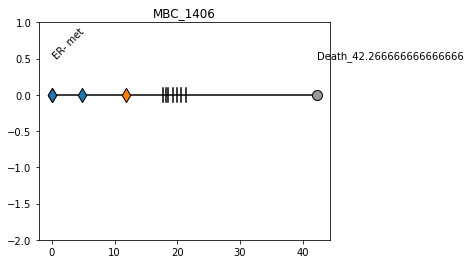

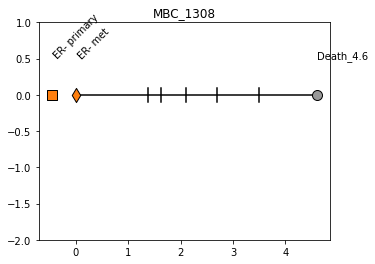

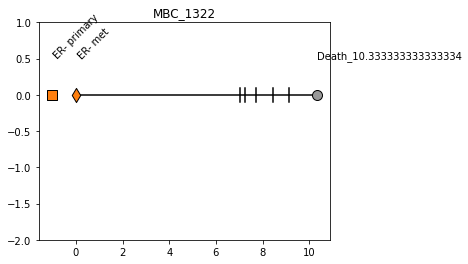

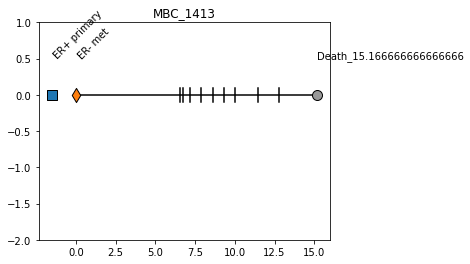

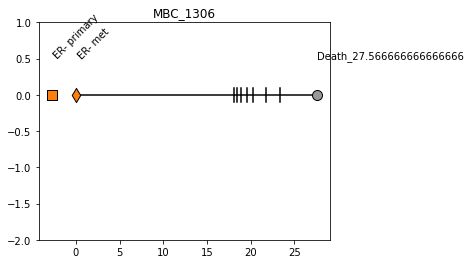

In [6]:
for ID in multi_time_points:
    current = metadata[metadata['TNBC_ULPWGS_ID']==ID]
    #print((current['merged_TimeFromMet_ToDeathOrLastFU_Days'].astype(int) == np.round(current['Stover_TimeFromMet_ToDeathOrLastFU_Days']).astype(int)).all())
    #print((current['Stover_DeathCensor'] == current['merged_DeathCensor']).all())

    fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)

    ax.set_title(current['patient_id'].iloc[0])
    ax.set_ylim(-2,1)

    met_status = current['merged_MetsEstrogenStatus'].unique()[0]

    
    if ID=='TNBC_ULPWGS_14' or ID == 'TNBC_ULPWGS_96':
        met_color = '.9'
    else:
        met_color = color_dict[met_status]



    #create timeline
    death_months = current['TimeFromMet_ToDeathOrLastFU_Months'].iloc[0]
    ax.plot([0,death_months],[0,0], color = 'black')
    #plot death time
    ax.scatter(death_months,0, facecolor = '.6',
            color='black', marker = 'o',s=100,edgecolor='black', zorder=3)
    
    #label death
    if current['merged_DeathCensor'].iloc[0]==1:
        plt.text(death_months,.5,'Death_'+str(death_months))

    #add primary
    primary_status = current['merged_PrimaryEstrogenStatus'].unique()[0]
    if ID=='TNBC_ULPWGS_96':
        pass
        #no primary
    else:
        primary_color = color_dict[primary_status]
        #add primary
        ax.scatter(-death_months/10,0,facecolor=primary_color, marker = 's',s=100, edgecolor='black', zorder=3)
        plt.text(-death_months/10,.5,'ER'+str(primary_status)+' primary', rotation = 45)


    #add met subtype
    ax.scatter(0,0.0, marker = 'd',s=100, facecolor=met_color, zorder=3, edgecolor='black')
    plt.text(0,.5,'ER'+str(met_status)+' met', rotation = 45)

    #add additional met biopsies
    if ID in additional_data_dict:
        for key in additional_data_dict[ID]:
            current_subtype = additional_data_dict[ID][key]['subtype']
            location = additional_data_dict[ID][key]['location']
            plt.scatter(key,0.0, marker = 'd',s=100, color = color_dict[current_subtype], zorder = 4, edgecolor='black')
            #plt.scatter(key,-0.02, marker = 6,s=100, color = color_dict[current_subtype])

    #add blood draws
    for i in current['met_to_processing_months']:
        plt.plot([i,i],[-.1,.1], color = 'black')

#     #add a dashed line
#     plt.plot([0,-death_months/10],[0,0], color = '.5', dashes = [2,2])


#     #add treatments
#     for i in range(1,7):
#         treatment_start = current['met_to_tx'+str(i)+'_months'].iloc[0]
#         treatment = current['MetTx'+str(i)+'_Description'].iloc[0]
#         if pd.isna(treatment_start):
#             continue
#         plt.scatter(treatment_start,-.2, marker = 5, s=80, color = treatment_dict[treatment])

#         plt.text(treatment_start,-1.5,treatment, color = treatment_dict[treatment], rotation = -45)
    plt.subplots_adjust(right = .8)
    plt.savefig('timelines/'+current['patient_id'].iloc[0]+'_timeline.pdf', transparent =True)
    fig.show()